# Pre

In [ ]:
!pip install neptune -qq
import neptune
import pandas as pd
# %% Train-Test split for time-series
stockprices = pd.read_excel("/content/drive/MyDrive/Chứng khoán/VCB_stock_data.xlsx", index_col="Ngay")

# reverse the dataframe
stockprices = stockprices.iloc[::-1]

test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))
print(f"train_size: {train_size}")
print(f"test_size: {test_size}")

train = stockprices[:train_size][["GiaDongCua"]]
test = stockprices[train_size:][["GiaDongCua"]]
import numpy as np

## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset
        N - window size, e.g., 50 for 50 days of historical stock prices
        offset - position to start the split
    """
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i-N : i])
        y.append(data[i : i+30])

    return np.array(X), np.array(y)

#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse


def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

def calculate_perf_metrics(var):
    ### RMSE
    rmse = calculate_rmse(
        np.array(stockprices[train_size:]["GiaDongCua"]),
        np.array(stockprices[train_size:][var]),
    )
    ### MAPE
    mape = calculate_mape(
        np.array(stockprices[train_size:]["GiaDongCua"]),
        np.array(stockprices[train_size:][var]),
    )

    ## Log to Neptune
    run["RMSE"] = rmse
    run["MAPE (%)"] = mape

    return rmse, mape
def plot_stock_trend(var, cur_title, stockprices=stockprices):
    ax = stockprices[["GiaDongCua", var, "200day"]].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis("tight")
    plt.ylabel("Stock Price ($)")

    ## Log to Neptune
    run["Plot of Stock Predictions"].upload(
        neptune.types.File.as_image(ax.get_figure())
    )
import matplotlib.pyplot as plt
window_size = 50

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.4/501.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.0 MB/s eta 0:00:00
ERROR: Operation cancelled by user
^C


ModuleNotFoundError: No module named 'neptune'

# SMA

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/tringuyen.uit/StockPrediction/e/STOC-2
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/tringuyen.uit/StockPrediction/e/STOC-2/metadata


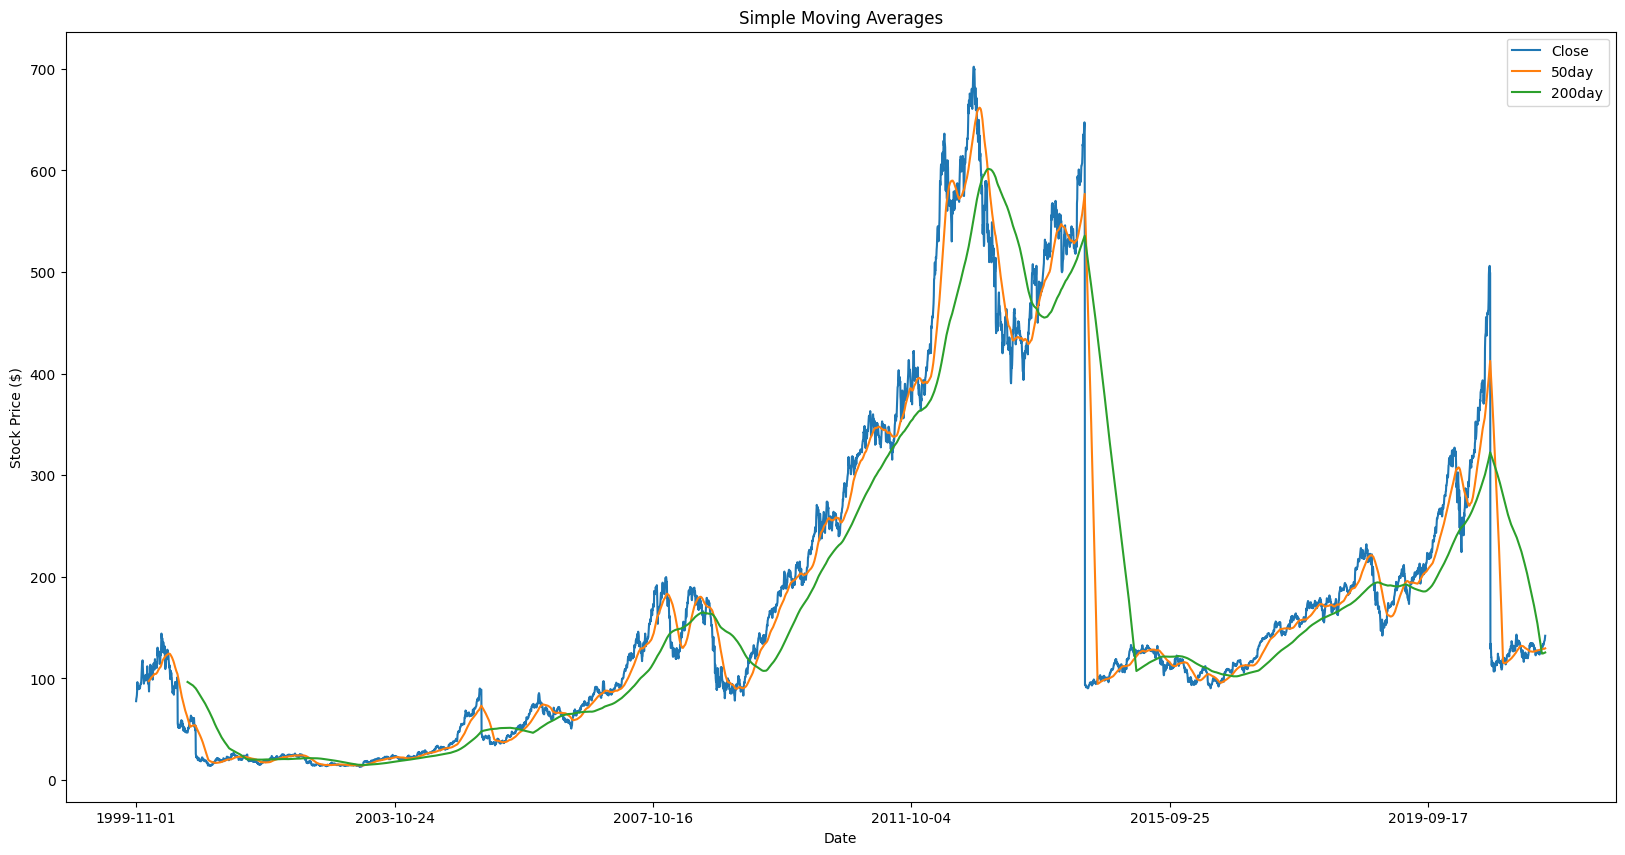

In [ ]:
# Initialize a Neptune run
run = neptune.init_run(
    project="tringuyen.uit/StockPrediction",
    name="SMA",
    description="stock-prediction-machine-learning",
    tags=["stockprediction", "MA_Simple", "neptune"],
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5Yzk1NWUyMS04ZDQ0LTRjZmMtODY2YS0wMzdjOTVmYmIxYzkifQ==",
)

window_var = f"{window_size}day"

stockprices[window_var] = stockprices["Close"].rolling(window_size).mean()

### Include a 200-day SMA for reference
stockprices["200day"] = stockprices["Close"].rolling(200).mean()

### Plot and performance metrics for SMA model
plot_stock_trend(var=window_var, cur_title="Simple Moving Averages")
rmse_sma, mape_sma = calculate_perf_metrics(var=window_var)

### Stop the run
run.stop()

In [ ]:
rmse_sma, mape_sma

(43.76848947969163, 12.529053089133422)

# EMA

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/tringuyen.uit/StockPrediction/e/STOC-3
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/tringuyen.uit/StockPrediction/e/STOC-3/metadata


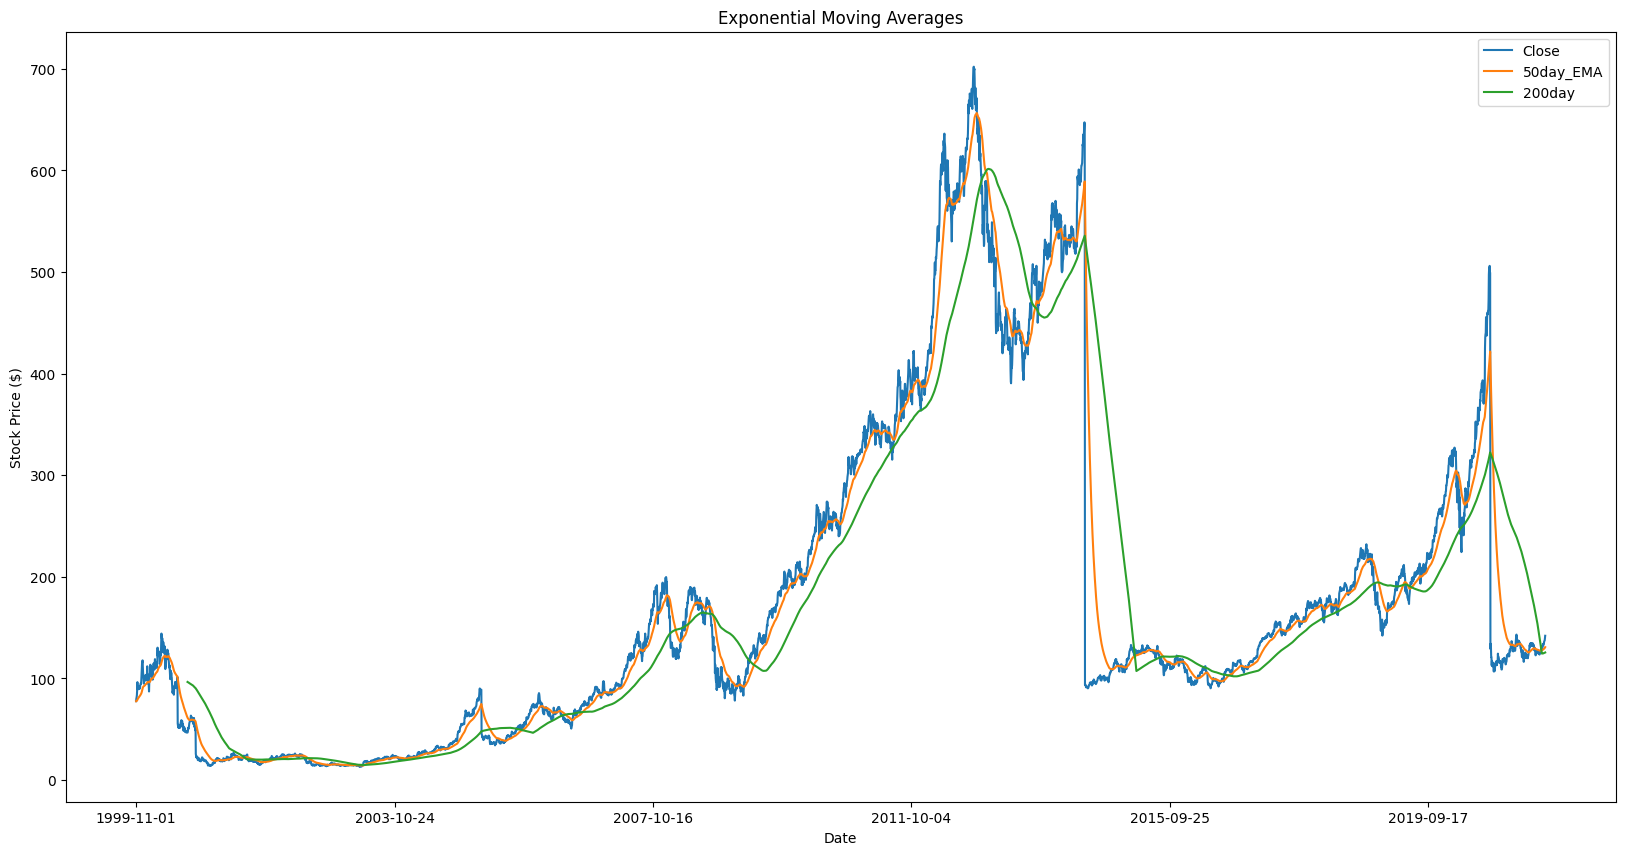

In [ ]:
# Initialize a Neptune run
run = neptune.init_run(
    project="tringuyen.uit/StockPrediction",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5Yzk1NWUyMS04ZDQ0LTRjZmMtODY2YS0wMzdjOTVmYmIxYzkifQ==",
    name="EMA",
    description="stock-prediction-machine-learning",
    tags=["stockprediction", "MA_Exponential", "neptune"],
)

###### Exponential MA
window_ema_var = f"{window_var}_EMA"

# Calculate the 50-day exponentially weighted moving average
stockprices[window_ema_var] = (
    stockprices["Close"].ewm(span=window_size, adjust=False).mean()
)
stockprices["200day"] = stockprices["Close"].rolling(200).mean()

### Plot and performance metrics for EMA model
plot_stock_trend(
    var=window_ema_var, cur_title="Exponential Moving Averages")
rmse_ema, mape_ema = calculate_perf_metrics(var=window_ema_var)

### Stop the run
run.stop()

In [ ]:
rmse_ema, mape_ema

(36.67593508712043, 10.71389916884245)

# LSTM 1

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/tringuyen.uit/StockPrediction/e/STOC-21
Epoch 1/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 84s 620ms/step - loss: 0.0845 - val_loss: 0.0512
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 73s 554ms/step - loss: 0.0295 - val_loss: 0.1020
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 75s 503ms/step - loss: 0.0282 - val_loss: 0.1508
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 82s 652ms/step - loss: 0.0266 - val_loss: 0.0542
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 136s 608ms/step - loss: 0.0265 - val_loss: 0.2756
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 75s 591ms/step - loss: 0.0311 - val_loss: 0.1482
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 80s 578ms/step - loss: 0.0273 - val_loss: 0.0440
Epoch 8/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 83s 583ms/step - loss: 0.0276 - val_loss: 0.0605
Epoch 9/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 93s 675ms/step - loss: 0.0259 - val_loss: 0.0750
Epoch 10/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 144s 691ms/step - loss: 0.0246 - val

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 373ms/step


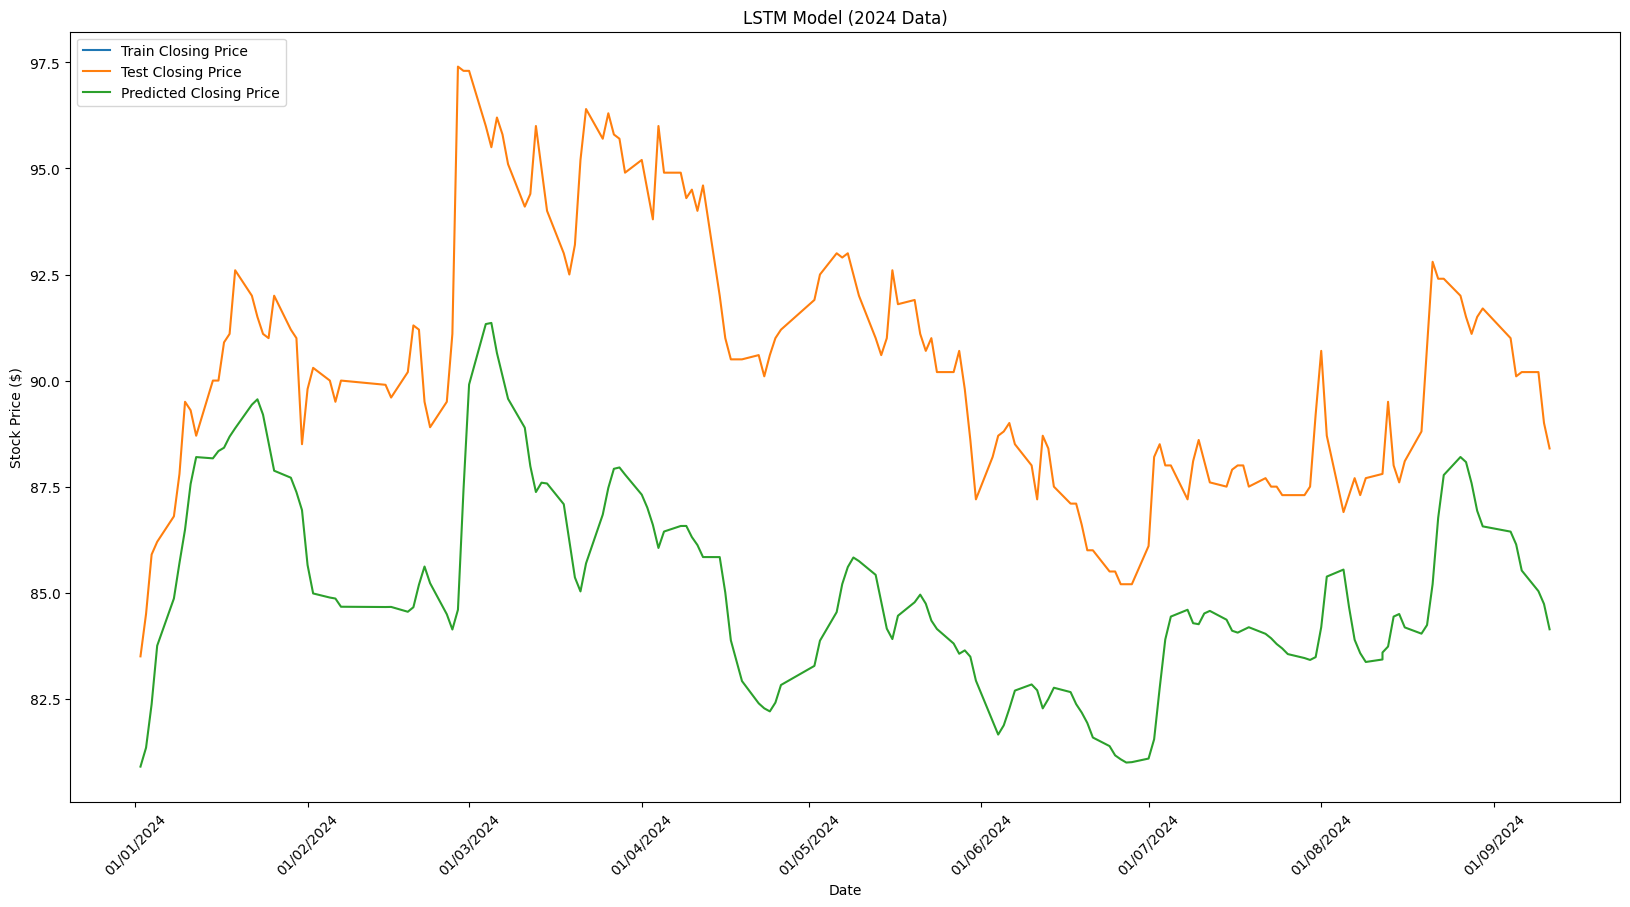

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/tringuyen.uit/StockPrediction/e/STOC-21/metadata


In [ ]:
layer_units = 50
optimizer = "adam"
cur_epochs = 15
cur_batch_size = 20

cur_LSTM_args = {
    "units": layer_units,
    "optimizer": optimizer,
    "batch_size": cur_batch_size,
    "epochs": cur_epochs,
}

# Initialize a Neptune run
run = neptune.init_run(
    project="tringuyen.uit/StockPrediction",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5Yzk1NWUyMS04ZDQ0LTRjZmMtODY2YS0wMzdjOTVmYmIxYzkifQ==",    name="LSTM",
    description="stock-prediction-machine-learning",
    tags=["stockprediction", "LSTM", "neptune"],
)
run["LSTM_args"] = cur_LSTM_args
from sklearn.preprocessing import StandardScaler

# Scale our dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[["GiaDongCua"]])
scaled_data_train = scaled_data[: train.shape[0]]

# We use past 50 days’ stock prices for our training to predict the 51th day's closing price.
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)
!pip install neptune_tensorflow_keras -qq
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Setup Neptune's Keras integration
from neptune.integrations.tensorflow_keras import NeptuneCallback

neptune_callback = NeptuneCallback(run=run)

# Build a LSTM model and log training progress to Neptune
def Run_LSTM(X_train, layer_units=100):
    inp = Input(shape=(X_train.shape[1], 1))

    x = LSTM(units=layer_units, return_sequences=True)(inp)
    x = LSTM(units=layer_units)(x)
    out = Dense(1, activation="linear")(x)
    model = Model(inp, out)

    # Compile the LSTM neural net
    model.compile(loss="mean_squared_error", optimizer="adam")

    return model

model = Run_LSTM(X_train, layer_units=layer_units)

history = model.fit(
    X_train,
    y_train,
    epochs=cur_epochs,
    batch_size=cur_batch_size,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[neptune_callback],
)
# predict stock prices using past window_size stock prices
def preprocess_testdat(data=stockprices, scaler=scaler, window_size=window_size, test=test):
    raw = data["GiaDongCua"][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)

    X_test = [raw[i-window_size:i, 0] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdat()

predicted_price_ = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# Plot predicted price vs actual closing price
test["Predictions_lstm"] = predicted_price

# Evaluate performance
rmse_lstm = calculate_rmse(np.array(test["GiaDongCua"]), np.array(test["Predictions_lstm"]))
mape_lstm = calculate_mape(np.array(test["GiaDongCua"]), np.array(test["Predictions_lstm"]))

### Log to Neptune
run["RMSE"] = rmse_lstm
run["MAPE (%)"] = mape_lstm
def plot_stock_trend_lstm(train, test):
    # Convert the index to datetime
    train.index = pd.to_datetime(train.index, format="%d/%m/%Y")
    test.index = pd.to_datetime(test.index, format="%d/%m/%Y")

    # Filter data for 2024
    train_2024 = train[train.index.year == 2024]
    test_2024 = test[test.index.year == 2024]

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(train_2024.index, train_2024["GiaDongCua"], label="Train Closing Price")
    ax.plot(test_2024.index, test_2024["GiaDongCua"], label="Test Closing Price")
    ax.plot(test_2024.index, test_2024["Predictions_lstm"], label="Predicted Closing Price")

    # Get the first day of each month
    months_train = train_2024.resample('MS').first().index  # 'MS' stands for Month Start
    months_test = test_2024.resample('MS').first().index

    # Combine train and test dates
    all_months = months_train.union(months_test)

    # Set the date format on the x-axis
    ax.set_xticks(all_months)
    ax.set_xticklabels(all_months.strftime("%d/%m/%Y"), rotation=45)

    plt.title("LSTM Model (2024 Data)")
    plt.xlabel("Date")
    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")

    # Log image to Neptune
    run["Plot of Stock Predictions"].upload(neptune.types.File.as_image(fig))

    plt.show()

plot_stock_trend_lstm(train, test)
### Stop the run after logging
run.stop()

# LSTM 2

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt

# Load and preprocess data
stockprices = pd.read_excel("/content/drive/MyDrive/Chứng khoán/VCB_stock_data.xlsx", index_col="Ngay")
stockprices = stockprices.iloc[::-1]

# Selecting the additional features
features = ['GiaDongCua', 'GiaCaoNhat', 'GiaThapNhat', 'GiaMoCua',
            'GiaDieuChinh',
            # 'KhoiLuongKhopLenh',
            # 'GiaTriKhopLenh',
            # 'KLThoaThuan',
            # 'GtThoaThuan'
            ]

# Train-Test split
test_ratio = 0.05
train_size = int((1 - test_ratio) * len(stockprices))
test_size = len(stockprices) - train_size

train = stockprices[:train_size][features]
test = stockprices[train_size:][features]

# Function to extract sequences
nday = 30
def extract_seqX_outcomeY(data, N, offset):
    X, y = [], []
    for i in range(offset, len(data) - nday):  # Predict 30 days ahead
        X.append(data[i-N : i])
        y.append(data[i : i+nday])  # Predicting 'GiaDongCua'
    return np.array(X), np.array(y)

# Model parameters
window_size = 60
layer_units = 10000
optimizer = "adamw"
cur_epochs = 15
cur_batch_size = 20

# Scale data for all features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[features])
scaled_data_train = scaled_data[:train.shape[0]]

# Prepare training data
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

# flatten y_train
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1] * len(features))

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * len(features))

def Run_Linear_Model(X_train, layer_units=layer_units):
    inp = Input(shape=(window_size * len(features),))  # Adjust input shape

    x = Dense(units=layer_units, activation="linear")(inp)
    x = Dense(units=layer_units, activation="linear")(x)
    # x = Dense(units=layer_units, activation="linear")(x)
    # x = Dense(units=layer_units, activation="linear")(x)
    # x = Dense(units=layer_units, activation="linear")(x)
    # x = Dense(units=layer_units, activation="linear")(x)
    out = Dense(nday * len(features), activation="linear")(x)

    model = Model(inp, out)

    # Compile the model
    model.compile(loss="mean_squared_error", optimizer=optimizer)

    return model

# Initialize model
model = Run_Linear_Model(X_train, layer_units=layer_units)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=cur_epochs,
    batch_size=cur_batch_size,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 36.0447 - val_loss: 0.0634
Epoch 2/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0636 - val_loss: 0.1082
Epoch 3/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0456 - val_loss: 0.0841
Epoch 4/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0417 - val_loss: 0.0516
Epoch 5/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0300 - val_loss: 0.0532
Epoch 6/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0286 - val_loss: 0.0963
Epoch 7/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0322 - val_loss: 0.0547
Epoch 8/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0306 - val_loss: 0.0478
Epoch 9/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0277 - val_loss: 0.0489
Epoch 10/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0300 - val_loss: 0.0985
Epoch 11/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0302 - val_loss: 0.0500
Epoch 12/15
159/159 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# with tf.device('/device:GPU:0'):  # Use GPU:0 (first GPU)
#     model = create_model(window_size)
#     history = model.fit(
#         X_train, y_train, epochs=cur_epochs, batch_size=cur_batch_size,
#         verbose=1, validation_split=0.1, shuffle=True
#     )

# # Prepare test data
def preprocess_testdat(data=stockprices, scaler=scaler, window_size=window_size, test=test):
    raw = stockprices[features][len(stockprices) - len(test) - window_size:].values
    raw = raw.reshape(-1, len(features))
    raw = scaler.transform(raw)

    X_test = [raw[i-window_size:i, :] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * len(features)))

    return X_test

X_test = preprocess_testdat()
y_test = test['GiaDongCua'].values.reshape(-1, 1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Predict
predicted_price = model.predict(X_test)
predicted_price = predicted_price.reshape(X_test.shape[0] * nday, len(features))
predicted_price = scaler.inverse_transform(predicted_price)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


In [ ]:
# plot
for i in range(len(y_test)-nday):
  plt.plot(y_test[i:i+nday], label='true', color='red')
  plt.plot(predicted_price[:nday, 0], label='predicted', color='blue')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Machine Learning

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.8 MB/s eta 0:00:00


In [ ]:
data = pd.read_excel("/content/drive/MyDrive/Chứng khoán/VN30_stock_data.xlsx")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93720 entries, 0 to 93719
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               93720 non-null  object 
 1   GiaDieuChinh       93720 non-null  float64
 2   GiaDongCua         93720 non-null  float64
 3   ThayDoi            93720 non-null  object 
 4   KhoiLuongKhopLenh  93720 non-null  int64  
 5   GiaTriKhopLenh     93720 non-null  int64  
 6   KLThoaThuan        93720 non-null  int64  
 7   GtThoaThuan        93720 non-null  int64  
 8   GiaMoCua           93720 non-null  float64
 9   GiaCaoNhat         93720 non-null  float64
 10  GiaThapNhat        93720 non-null  float64
 11  Company code       93720 non-null  object 
dtypes: float64(5), int64(4), object(3)
memory usage: 8.6+ MB


In [ ]:
data[['Day', 'Month', 'Year']] = data['Ngay'].str.split('/', expand=True)
data['Day'] = data['Day'].astype(int)
data['Month'] = data['Month'].astype(int)
data['Year'] = data['Year'].astype(int)
data = data.drop(columns=['Ngay'])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
year = 2024
month = 5
c_code = "VCB"

In [ ]:
data[(data['Year']<=year) & (data['Month']<month) & (data['Company code'] == c_code)]

,GiaDieuChinh,GiaDongCua,ThayDoi,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,Company code,Day,Month,Year
67991,91.20,91.2,0.2(0.22 %),1698300,156699000000,65000,5961500000,91.7,93.3,91.2,VCB,26,4,2024
67992,91.00,91.0,0.4(0.44 %),1235700,113323000000,99000,8972700000,90.6,92.9,90.5,VCB,25,4,2024
67993,90.60,90.6,0.5(0.55 %),1925200,174556000000,65000,6107500000,91.0,91.1,90.1,VCB,24,4,2024
67994,90.10,90.1,-0.5(-0.55 %),1562900,140708000000,99000,8976200000,90.6,91.2,89.2,VCB,23,4,2024
67995,90.60,90.6,0.1(0.11 %),999100,90635000000,65000,6187000000,90.5,91.4,90.2,VCB,22,4,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71556,10.77,47.0,0(0.00 %),351610,16647340000,0,0,47.6,47.8,46.9,VCB,8,1,2010
71557,10.77,47.0,-1(-2.08 %),207490,9874093000,0,0,48.0,48.1,47.0,VCB,7,1,2010
71558,11.00,48.0,-1.8(-3.61 %),479840,23321670000,0,0,48.1,49.8,48.0,VCB,6,1,2010
71559,11.42,49.8,0.5(1.01 %),935140,47232544000,0,0,51.0,51.5,49.3,VCB,5,1,2010


In [ ]:
df1 = data[data['Company code'] == c_code]
df1 = df1[df1['Year']<=year]
df1 = df1[~((df1['Month']>=month) & (df1['Year']==year))]
df1

,GiaDieuChinh,GiaDongCua,ThayDoi,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,Company code,Day,Month,Year
67991,91.20,91.2,0.2(0.22 %),1698300,156699000000,65000,5961500000,91.7,93.3,91.2,VCB,26,4,2024
67992,91.00,91.0,0.4(0.44 %),1235700,113323000000,99000,8972700000,90.6,92.9,90.5,VCB,25,4,2024
67993,90.60,90.6,0.5(0.55 %),1925200,174556000000,65000,6107500000,91.0,91.1,90.1,VCB,24,4,2024
67994,90.10,90.1,-0.5(-0.55 %),1562900,140708000000,99000,8976200000,90.6,91.2,89.2,VCB,23,4,2024
67995,90.60,90.6,0.1(0.11 %),999100,90635000000,65000,6187000000,90.5,91.4,90.2,VCB,22,4,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71688,13.41,58.5,2.5(4.46 %),1571740,90182635000,0,0,56.0,58.5,56.0,VCB,6,7,2009
71689,12.84,56.0,-2(-3.45 %),899720,50678150000,42000,2541000000,56.5,57.0,56.0,VCB,3,7,2009
71690,13.30,58.0,-2.5(-4.13 %),1515670,88933635000,40000,2310000000,59.5,60.0,57.5,VCB,2,7,2009
71691,13.87,60.5,0.5(0.83 %),6248390,389785020000,3410000,212430000000,63.0,63.0,59.5,VCB,1,7,2009


Company: POW
Model: CatBoostRegressor
MSE: 3.606704545454544
R2 Score: -518.5372023809522
Month: 1
Year: 2024


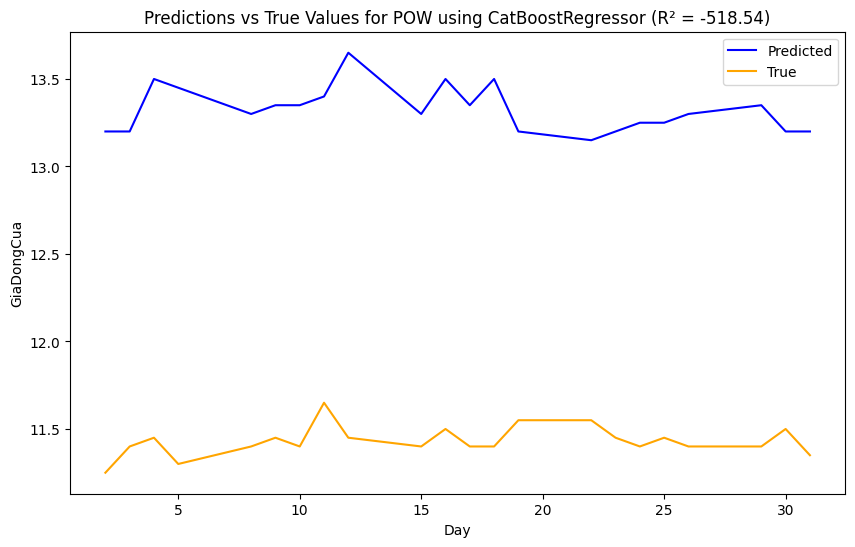


Company: POW
Model: CatBoostRegressor
MSE: 0.05109374999999994
R2 Score: 0.015060240963857607
Month: 2
Year: 2024


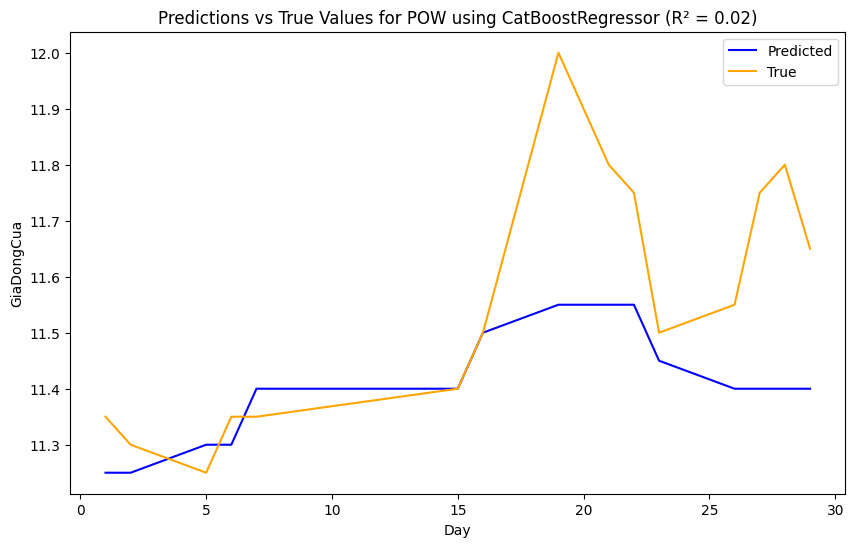


Company: POW
Model: CatBoostRegressor
MSE: 0.13023809523809524
R2 Score: -2.812479256554936
Month: 3
Year: 2024


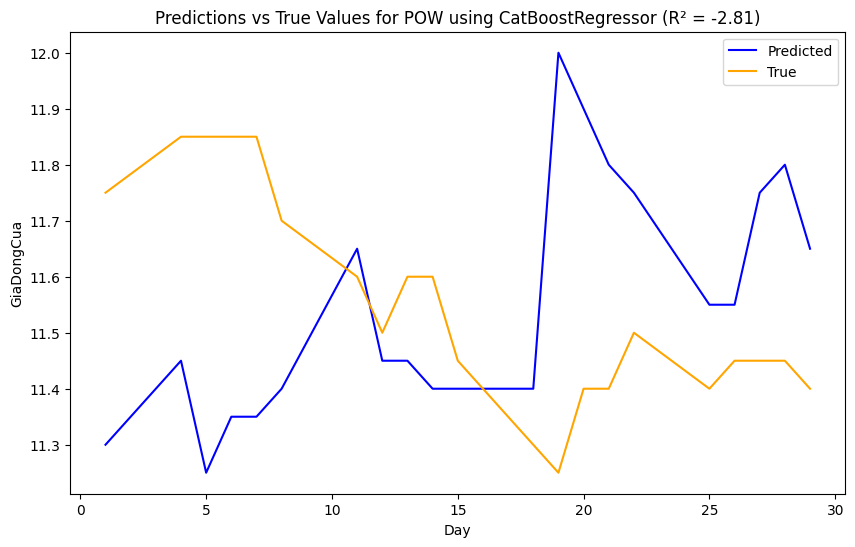


Company: POW
Model: CatBoostRegressor
MSE: 0.36697368421052595
R2 Score: -2.1101655123840772
Month: 4
Year: 2024


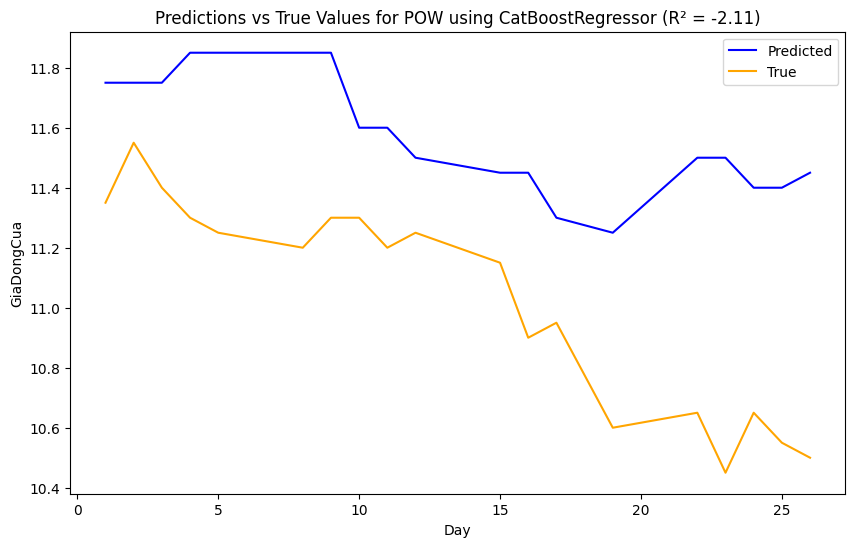


Company: POW
Model: CatBoostRegressor
MSE: 1.1054545454545457
R2 Score: -2.1580687049935063
Month: 5
Year: 2024


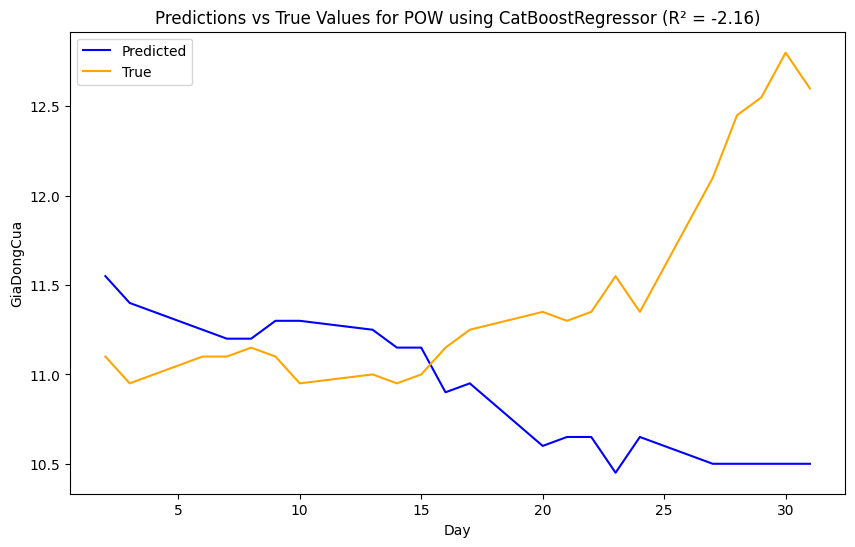


Company: POW
Model: CatBoostRegressor
MSE: 10.353125000000002
R2 Score: -29.17359150439899
Month: 6
Year: 2024


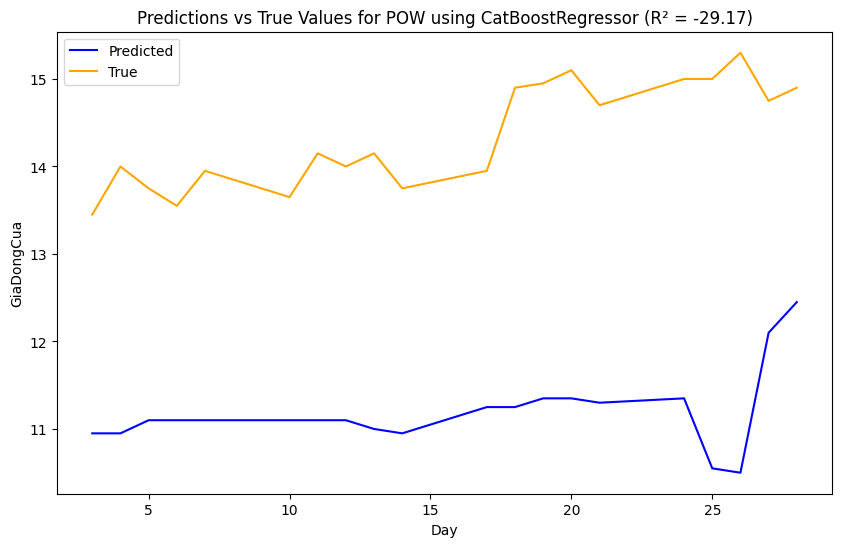


Company: POW
Model: CatBoostRegressor
MSE: 1.9458695652173914
R2 Score: -1.9082215002118939
Month: 7
Year: 2024


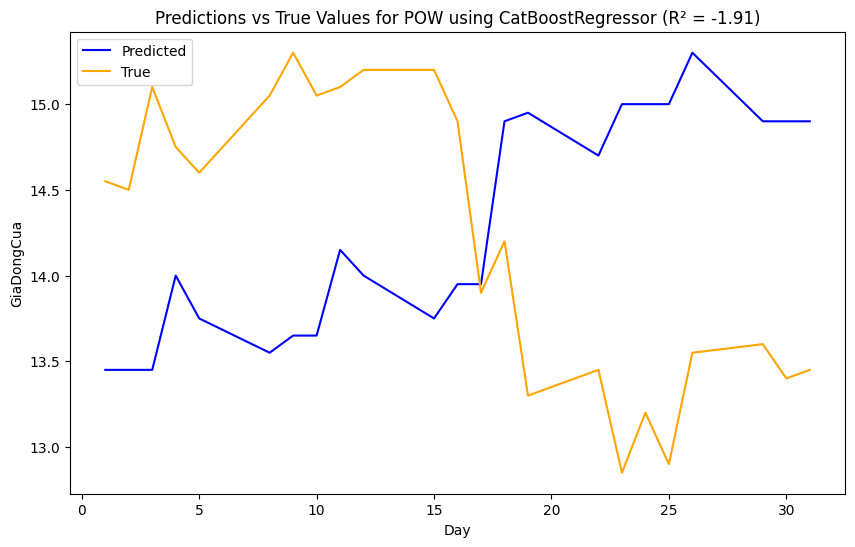


Company: POW
Model: CatBoostRegressor
MSE: 1.2276136363636359
R2 Score: -27.9377815658103
Month: 8
Year: 2024


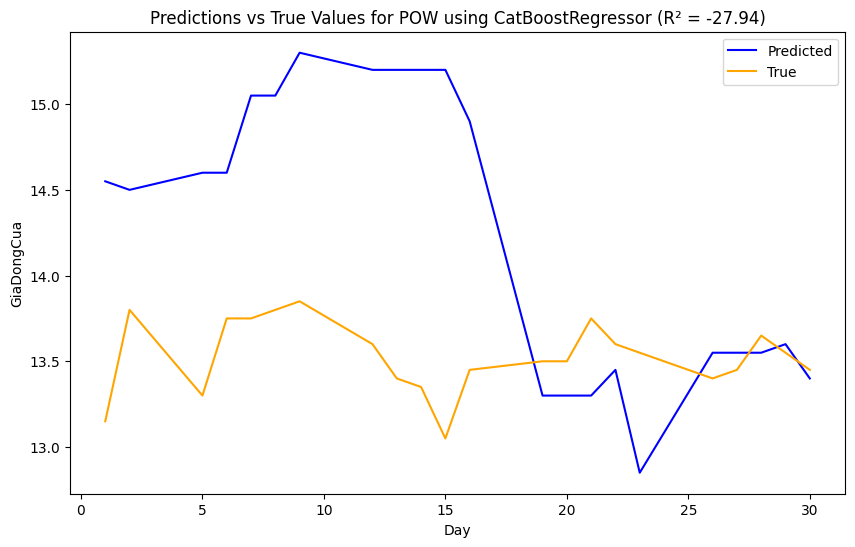


Company: POW
Model: CatBoostRegressor
MSE: 0.5352499999999998
R2 Score: -7.347792182473929
Month: 9
Year: 2024


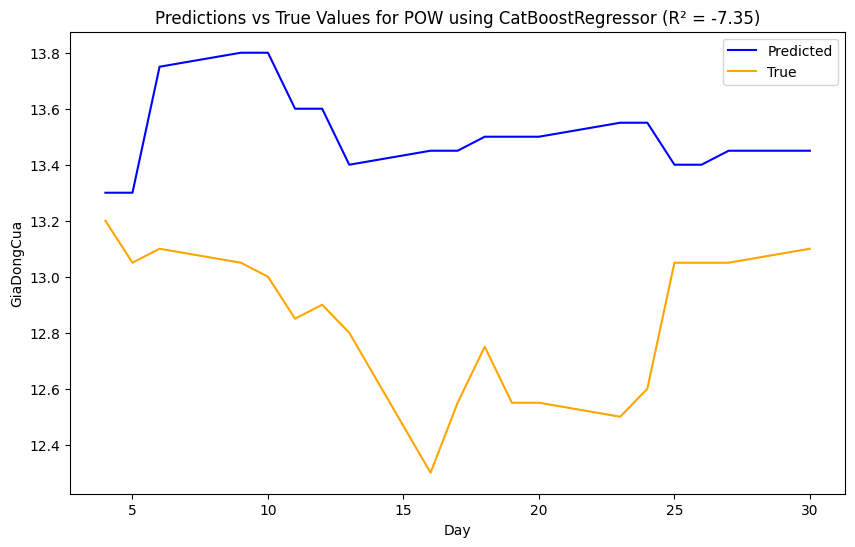


Company: POW
Model: CatBoostRegressor
MSE: 0.0694999999999997
R2 Score: -1.131901840490794
Month: 10
Year: 2024


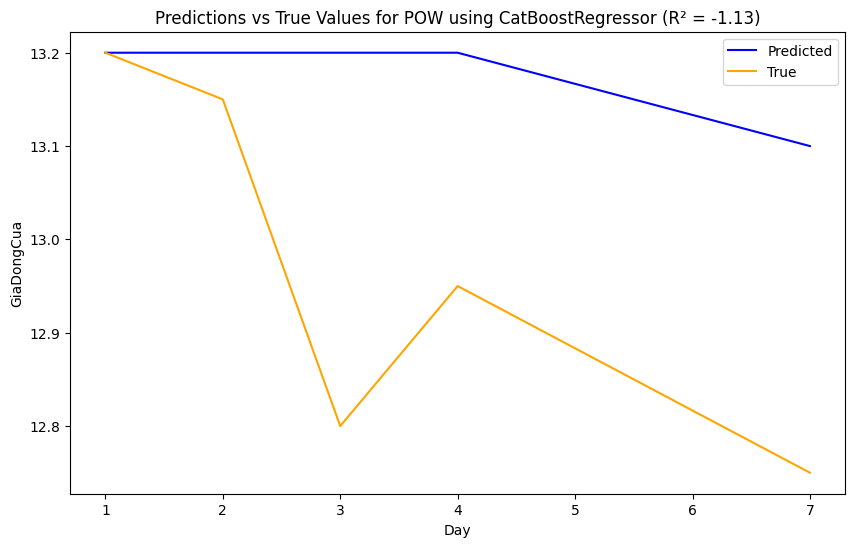


Company: HPG
Model: CatBoostRegressor
MSE: 57.641818181818174
R2 Score: -463.51282051281987
Month: 1
Year: 2024


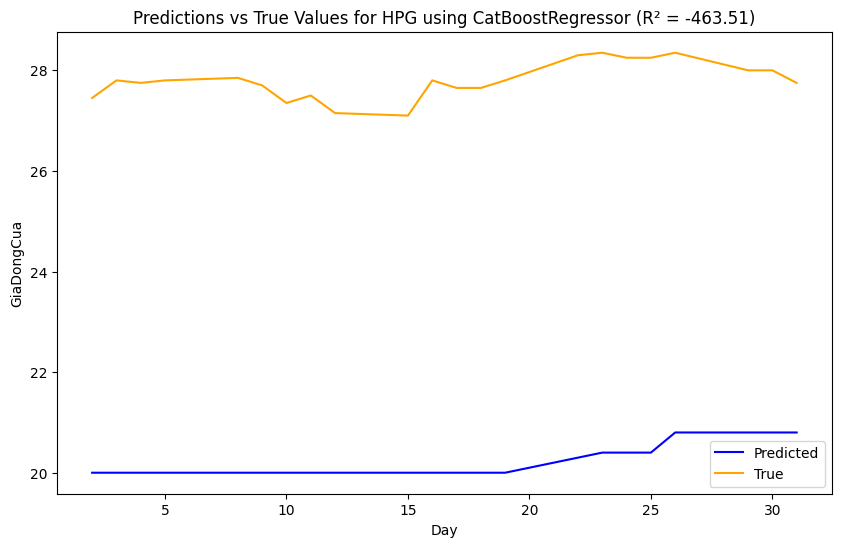


Company: HPG
Model: CatBoostRegressor
MSE: 1.7470312499999996
R2 Score: -0.9549125241774199
Month: 2
Year: 2024


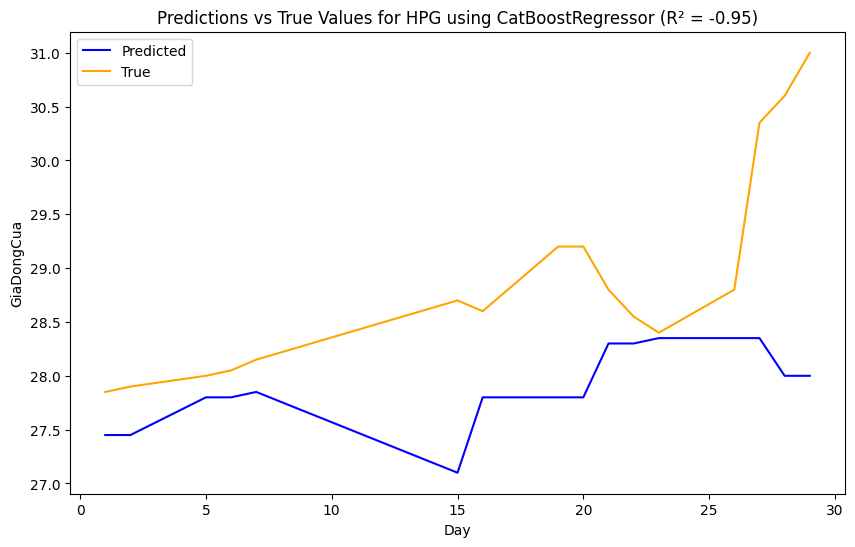


Company: HPG
Model: CatBoostRegressor
MSE: 3.4776190476190503
R2 Score: -21.609907120743056
Month: 3
Year: 2024


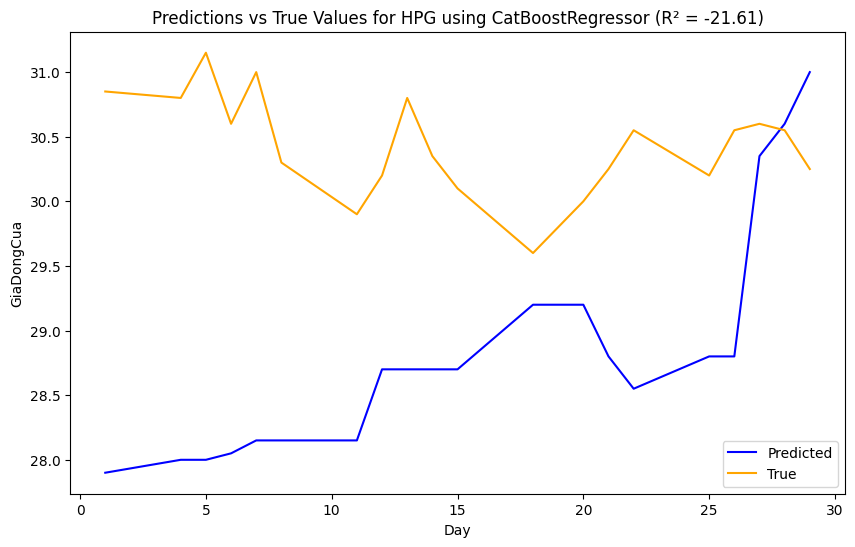


Company: HPG
Model: CatBoostRegressor
MSE: 2.410789473684211
R2 Score: -2.1597110025958974
Month: 4
Year: 2024


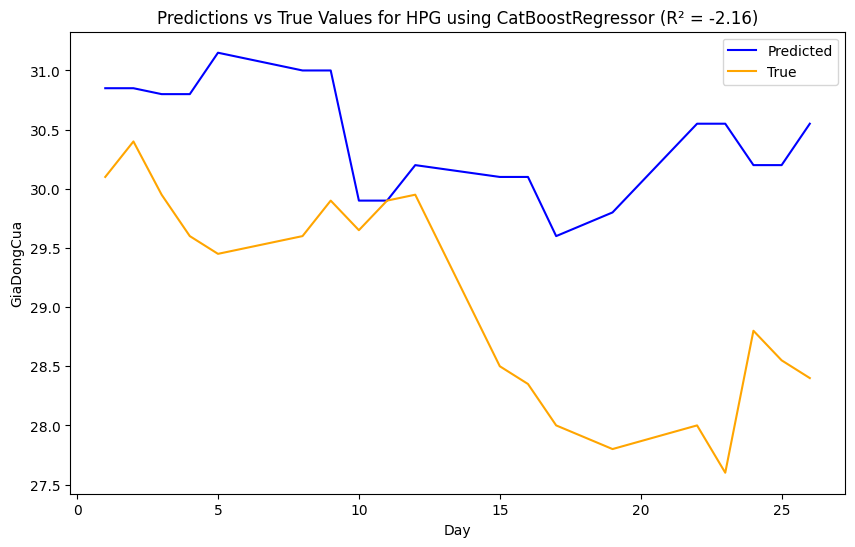


Company: HPG
Model: CatBoostRegressor
MSE: 4.091931818181817
R2 Score: -1.8062274176408066
Month: 5
Year: 2024


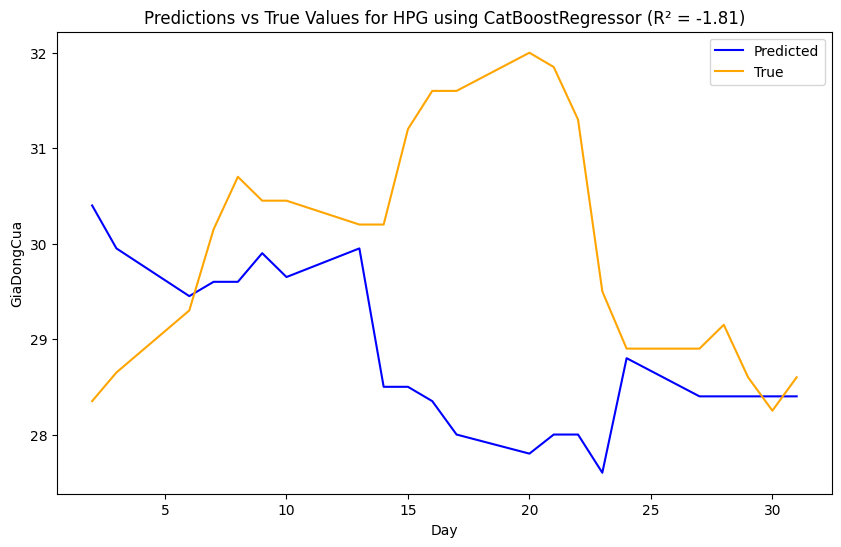


Company: HPG
Model: CatBoostRegressor
MSE: 1.9313749999999992
R2 Score: -18.578053725291408
Month: 6
Year: 2024


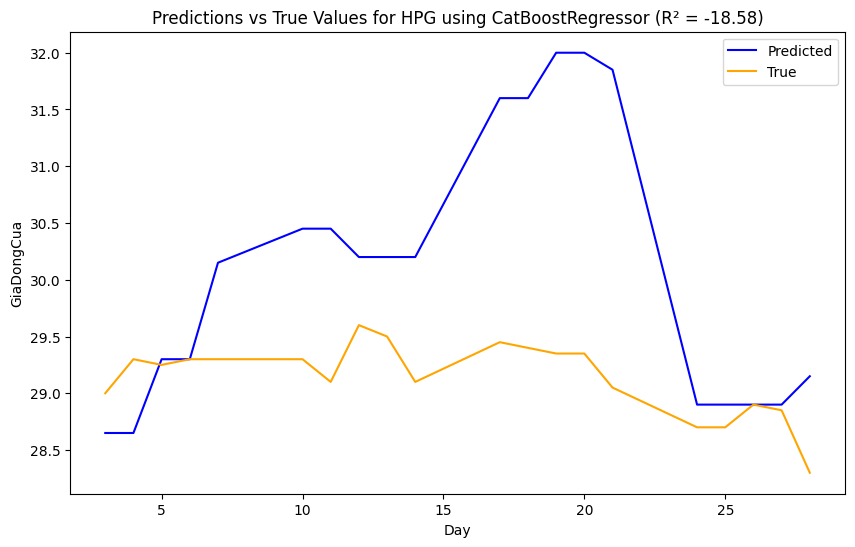


Company: HPG
Model: CatBoostRegressor
MSE: 0.8576086956521746
R2 Score: -2.26608113458839
Month: 7
Year: 2024


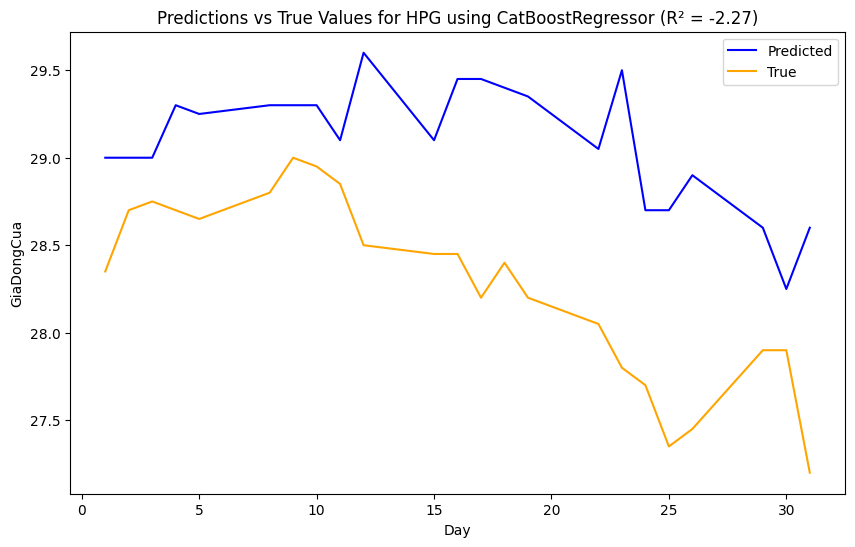


Company: HPG
Model: CatBoostRegressor
MSE: 6.026704545454542
R2 Score: -30.310076479270077
Month: 8
Year: 2024


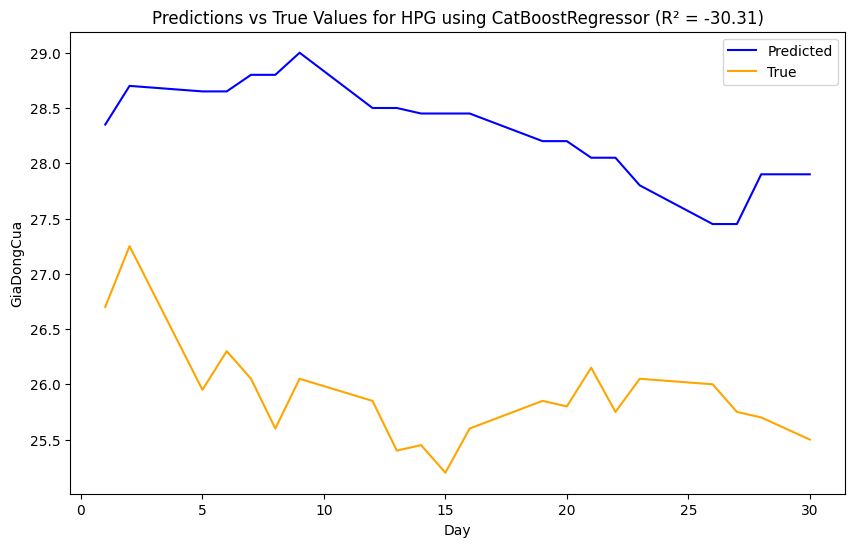


Company: HPG
Model: CatBoostRegressor
MSE: 0.29662500000000047
R2 Score: -0.6673693086003398
Month: 9
Year: 2024


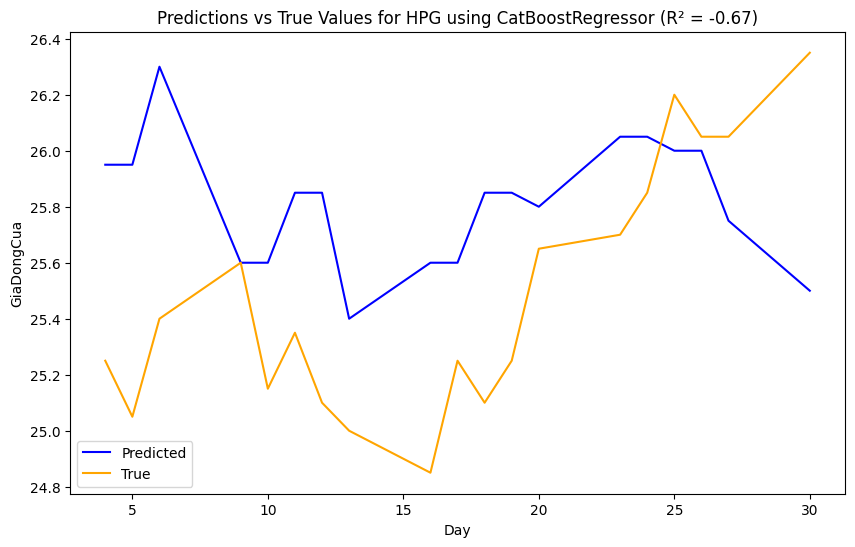


Company: HPG
Model: CatBoostRegressor
MSE: 0.7819999999999997
R2 Score: -17.798076923076888
Month: 10
Year: 2024


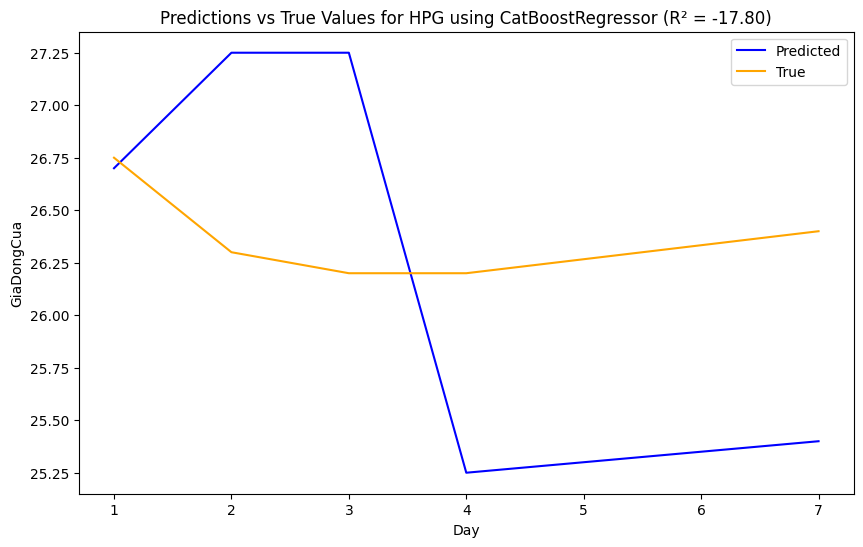


Company: SSI
Model: CatBoostRegressor
MSE: 191.38659090909093
R2 Score: -1017.7079071813495
Month: 1
Year: 2024


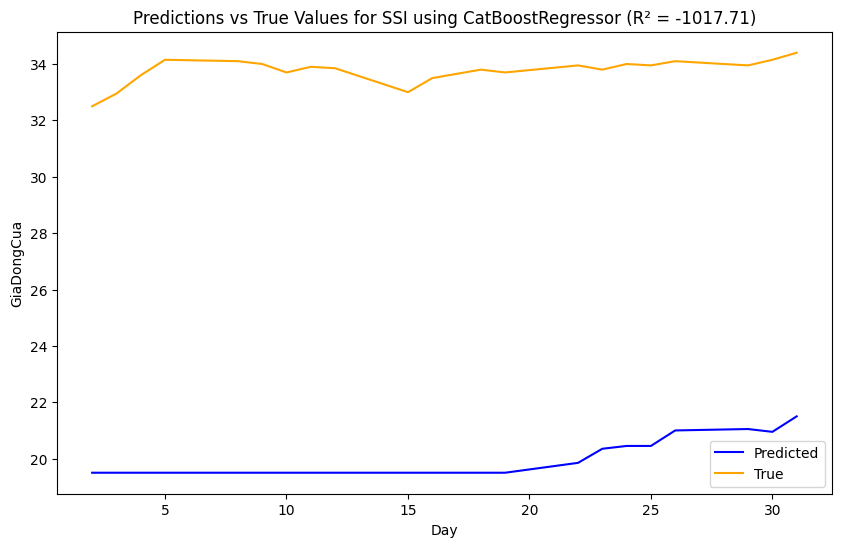


Company: SSI
Model: CatBoostRegressor
MSE: 2.720156249999996
R2 Score: -5.546121125237937
Month: 2
Year: 2024


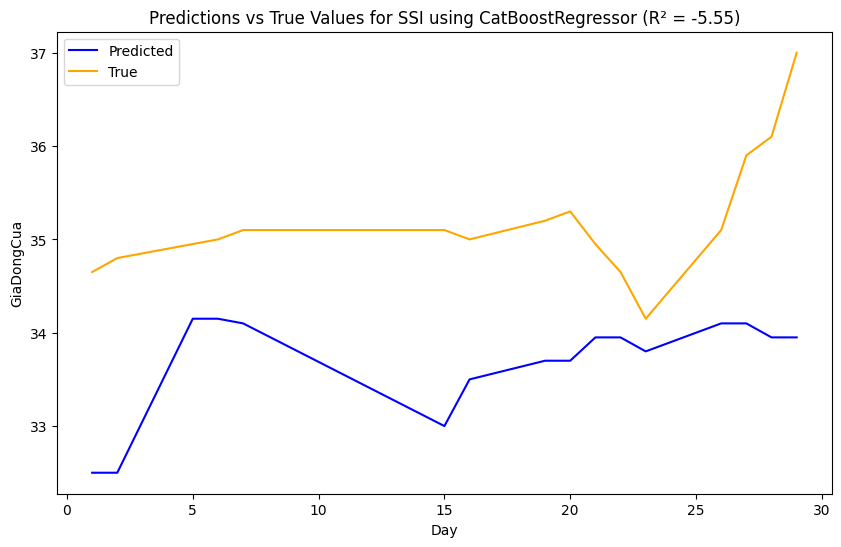


Company: SSI
Model: CatBoostRegressor
MSE: 5.366904761904757
R2 Score: -8.418432519548723
Month: 3
Year: 2024


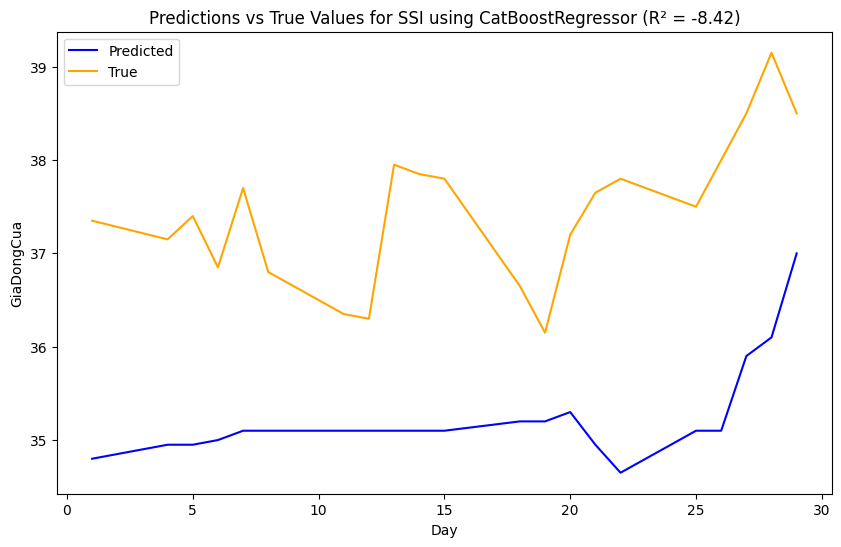


Company: SSI
Model: CatBoostRegressor
MSE: 3.8021052631578853
R2 Score: -0.5731887629374064
Month: 4
Year: 2024


KeyboardInterrupt: 

In [ ]:
# Load company codes from VN30.xlsx
vn30_df = pd.read_excel('/content/drive/MyDrive/Chứng khoán/VN30.xlsx')
company_codes = vn30_df['Mã CK'].unique()

# Loop through each company in VN30
for c_code in company_codes:
    for year in range(2024, 2025):
      for month in range(1, 13):
            ## 1
            # Filter data
            df1 = data[data['Company code'] == c_code]
            df1 = df1[df1['Year']<=year]
            df1 = df1[~((df1['Month']>=month) & (df1['Year']==year))].head(200)

            if df1.empty:
                continue

            # Separate the features (X) and the target (y)
            X = df1[['Day', 'Month', 'Year', 'Company code']]
            y = df1['GiaDongCua']

            # Split the data into a test subset (smaller portion) and a training subset (larger portion)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
            numerical_columns = X.select_dtypes(exclude='object').columns
            categorical_columns = X_train.select_dtypes(include='object').columns
            categorical_column_indices = [X_train.columns.get_loc(col) for col in categorical_columns]

            # Encode categorical features
            X_encoded = X.copy()
            for feature in categorical_columns:
                label_encoder = LabelEncoder()
                X_encoded[feature] = label_encoder.fit_transform(X_encoded[feature])

            X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.01, random_state=42)

            # Regressors with categorical features
            models_with_categorical = [
                DecisionTreeRegressor(),
                RandomForestRegressor(),
                GradientBoostingRegressor(),
                XGBRegressor(),
                CatBoostRegressor(verbose=False)
            ]

            # Train models with categorical features
            for model in models_with_categorical:
                model.fit(X_train_encoded, y_train)

            ## 2
            test1 = data[(data['Month'] == month) & (data['Year'] == year) & (data['Company code'] == c_code)]
            if test1.empty:
              continue

            X_test_company = test1[['Day', 'Month', 'Year', 'Company code']]
            y_test_company = test1['GiaDongCua']

            X_test_company_encoded = X_test_company.copy()
            for feature in categorical_columns:
                label_encoder = LabelEncoder()
                X_test_company_encoded[feature] = label_encoder.fit_transform(X_test_company_encoded[feature])

            # Loop through each model in models_with_categorical and plot if R² score > 0.5
            # for model in models_with_categorical:
            predictions = models_with_categorical[0].predict(X_test_company_encoded)
            mse = mean_squared_error(y_test_company, predictions)
            r2 = r2_score(y_test_company, predictions)

            # Only plot if R² score is greater than 0.5
            # if r2 > 0.25:
            print(f"Company: {c_code}")
            print(f"Model: {type(model).__name__}")
            print(f"MSE: {mse}")
            print(f"R2 Score: {r2}")
            print(f"Month: {month}")
            print(f"Year: {year}")

            # Plot predictions and true values
            plt.figure(figsize=(10, 6))
            plt.plot(test1['Day'], predictions, label='Predicted', color='blue')
            plt.plot(test1['Day'], y_test_company, label='True', color='orange')
            plt.title(f'Predictions vs True Values for {c_code} using {type(model).__name__} (R² = {r2:.2f})')
            plt.xlabel('Day')
            plt.ylabel('GiaDongCua')
            plt.legend()
            plt.show()
            print()